In [78]:
import cv2
import torchxrayvision as xrv
import skimage, torch, torchvision
import matplotlib.pyplot as plt

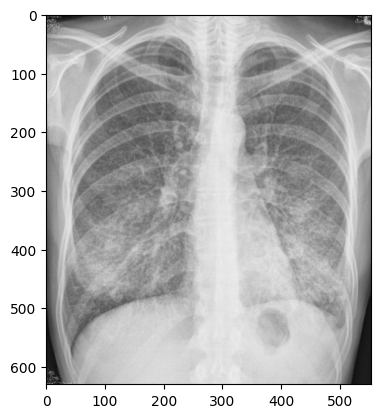

In [89]:
img_path = "/home/adarsha/Downloads/penumoia-2.jpg"
img = skimage.io.imread(img_path)
plt.imshow(img)

img = xrv.datasets.normalize(img, 255)  


if img.ndim == 3:  # convert to grayscale
    img = img.mean(2)

img = img[None, ...]  
transform = torchvision.transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)
])
img = transform(img)
img = torch.from_numpy(img)
# img_tensor = torch.from_numpy(img).unsqueeze(0)  


In [88]:
# Load model and process image
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()

XRV-DenseNet121-densenet121-res224-all

In [90]:
# Print results
outputs = model(img[None,...]) # or model.features(img[None,...])
dict(zip(model.pathologies,outputs[0].detach().numpy()))


{'Atelectasis': np.float32(0.057655603),
 'Consolidation': np.float32(0.5367843),
 'Infiltration': np.float32(0.73040247),
 'Pneumothorax': np.float32(0.50008774),
 'Edema': np.float32(0.02368405),
 'Emphysema': np.float32(0.507843),
 'Fibrosis': np.float32(0.37341192),
 'Effusion': np.float32(0.06673573),
 'Pneumonia': np.float32(0.9580447),
 'Pleural_Thickening': np.float32(0.14242442),
 'Cardiomegaly': np.float32(0.0063833585),
 'Nodule': np.float32(0.5419681),
 'Mass': np.float32(0.5057136),
 'Hernia': np.float32(7.693863e-05),
 'Lung Lesion': np.float32(0.0005249017),
 'Fracture': np.float32(0.038829897),
 'Lung Opacity': np.float32(0.9714248),
 'Enlarged Cardiomediastinum': np.float32(0.25646356)}

In [ ]:
# {'Atelectasis': np.float32(0.073938705),
#  'Consolidation': np.float32(0.30525684),
#  'Infiltration': np.float32(0.52344847),
#  'Pneumothorax': np.float32(0.50107473),
#  'Edema': np.float32(0.018877128),
#  'Emphysema': np.float32(0.13769925),
#  'Fibrosis': np.float32(0.08419923),
#  'Effusion': np.float32(0.18188517),
#  'Pneumonia': np.float32(0.041293103),
#  'Pleural_Thickening': np.float32(0.09147302),
#  'Cardiomegaly': np.float32(0.33668557),
#  'Nodule': np.float32(0.15369031),
#  'Mass': np.float32(0.18807676),
#  'Hernia': np.float32(0.00041259505),
#  'Lung Lesion': np.float32(0.0026615502),
#  'Fracture': np.float32(0.14757738),
#  'Lung Opacity': np.float32(0.31718445),
#  'Enlarged Cardiomediastinum': np.float32(0.5466526)}

In [91]:
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [37]:
model.eval()

XRV-DenseNet121-densenet121-res224-all

In [42]:
model.pathologies.index("Pneumonia")


8

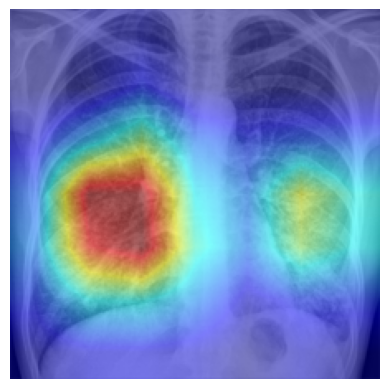

Predicted probabilities for all pathologies:

 0. Atelectasis              : 51.4410
 1. Consolidation            : 63.1064
 2. Infiltration             : 67.4894
 3. Pneumothorax             : 62.2480
 4. Edema                    : 50.5921
 5. Emphysema                : 62.4301
 6. Fibrosis                 : 59.2283
 7. Effusion                 : 51.6678
 8. Pneumonia                : 72.2730
 9. Pleural_Thickening       : 53.5546
10. Cardiomegaly             : 50.1596
11. Nodule                   : 63.2270
12. Mass                     : 62.3801
13. Hernia                   : 50.0019
14. Lung Lesion              : 50.0131
15. Fracture                 : 50.9706
16. Lung Opacity             : 72.5403
17. Enlarged Cardiomediastinum: 56.3767


In [97]:


img_tensor = img.unsqueeze(0)

target_class = model.pathologies.index("Pneumonia")

target_layer = model.features[-1]  # last conv layer
cam = GradCAM(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
grayscale_cam = grayscale_cam[0, :]  # shape: [224, 224]

# img[0] has shape (224, 224). Stack it three times to create a 3-channel image.
rgb_img = np.stack([img[0], img[0], img[0]], axis=-1)

# Normalize the image to a float range [0, 1]
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.axis('off')
plt.show()

#Inference on all classes
with torch.no_grad():
    output = model(img_tensor)[0]  

probabilities = torch.sigmoid(output)

print("Predicted probabilities for all pathologies:\n")
for idx, (pathology, prob) in enumerate(zip(model.pathologies, probabilities)):
    print(f"{idx:2d}. {pathology:25s}: {prob.item() * 100:.4f}")


